# Load Module

## Preparation

git clone https://github.com/zalandoresearch/fashion-mnist.git


cd fashion-mnist

My Github: https://github.com/haohan723/Distributed-Deep-Learning

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
import keras
import mnist_reader
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.contrib import tensorboard 

/home/hf/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [2]:
train_images, train_labels = mnist_reader.load_mnist('data/fashion', kind='train')
test_images,test_labels = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [3]:
print("Training images shape: {shape}".format(shape=train_images.shape))
print("Training labels shape: {shape}".format(shape=train_labels.shape))

# Shapes of test set
print("Test images shape: {shape}".format(shape=test_images.shape))
print("Test labels shape: {shape}".format(shape=test_labels.shape))

Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (10000, 784)
Test labels shape: (10000,)


## Create a dictionary of integer labels 

In [4]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Data Preprocession

In [5]:
num_classes = 10
x_train = train_images.reshape([-1,28,28,1])
x_test= test_images.reshape([-1,28,28,1])
y_train = keras.utils.to_categorical(np.ravel(train_labels), num_classes)
y_test = keras.utils.to_categorical(np.ravel(test_labels), num_classes)

In [6]:
#Shape of Training set
print("Training images shape: {shape}".format(shape=x_train.shape))
print("Training labels shape: {shape}".format(shape=y_train.shape))

# Shapes of Test set
print("Test images shape: {shape}".format(shape=x_test.shape))
print("Test labels shape: {shape}".format(shape=y_test.shape))

Training images shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)


## Plot data

In [7]:
image_shape = (28,28)
def plot_image(images, labels, labels_pred = None):
    fig, axes = plt.subplots(3,3)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        if labels_pred is None: 
            xlabel = 'True: {0}'.format(labels[i])
        else: 
            xlabel = 'True: {0}, Pred: {1}'.format(labels[i],labels_pred[i])            
        ax.set_xlabel(xlabel)
        ax.grid(False)      
        ax.set_yticks([])
        ax.set_yticks([])
        
    plt.show()

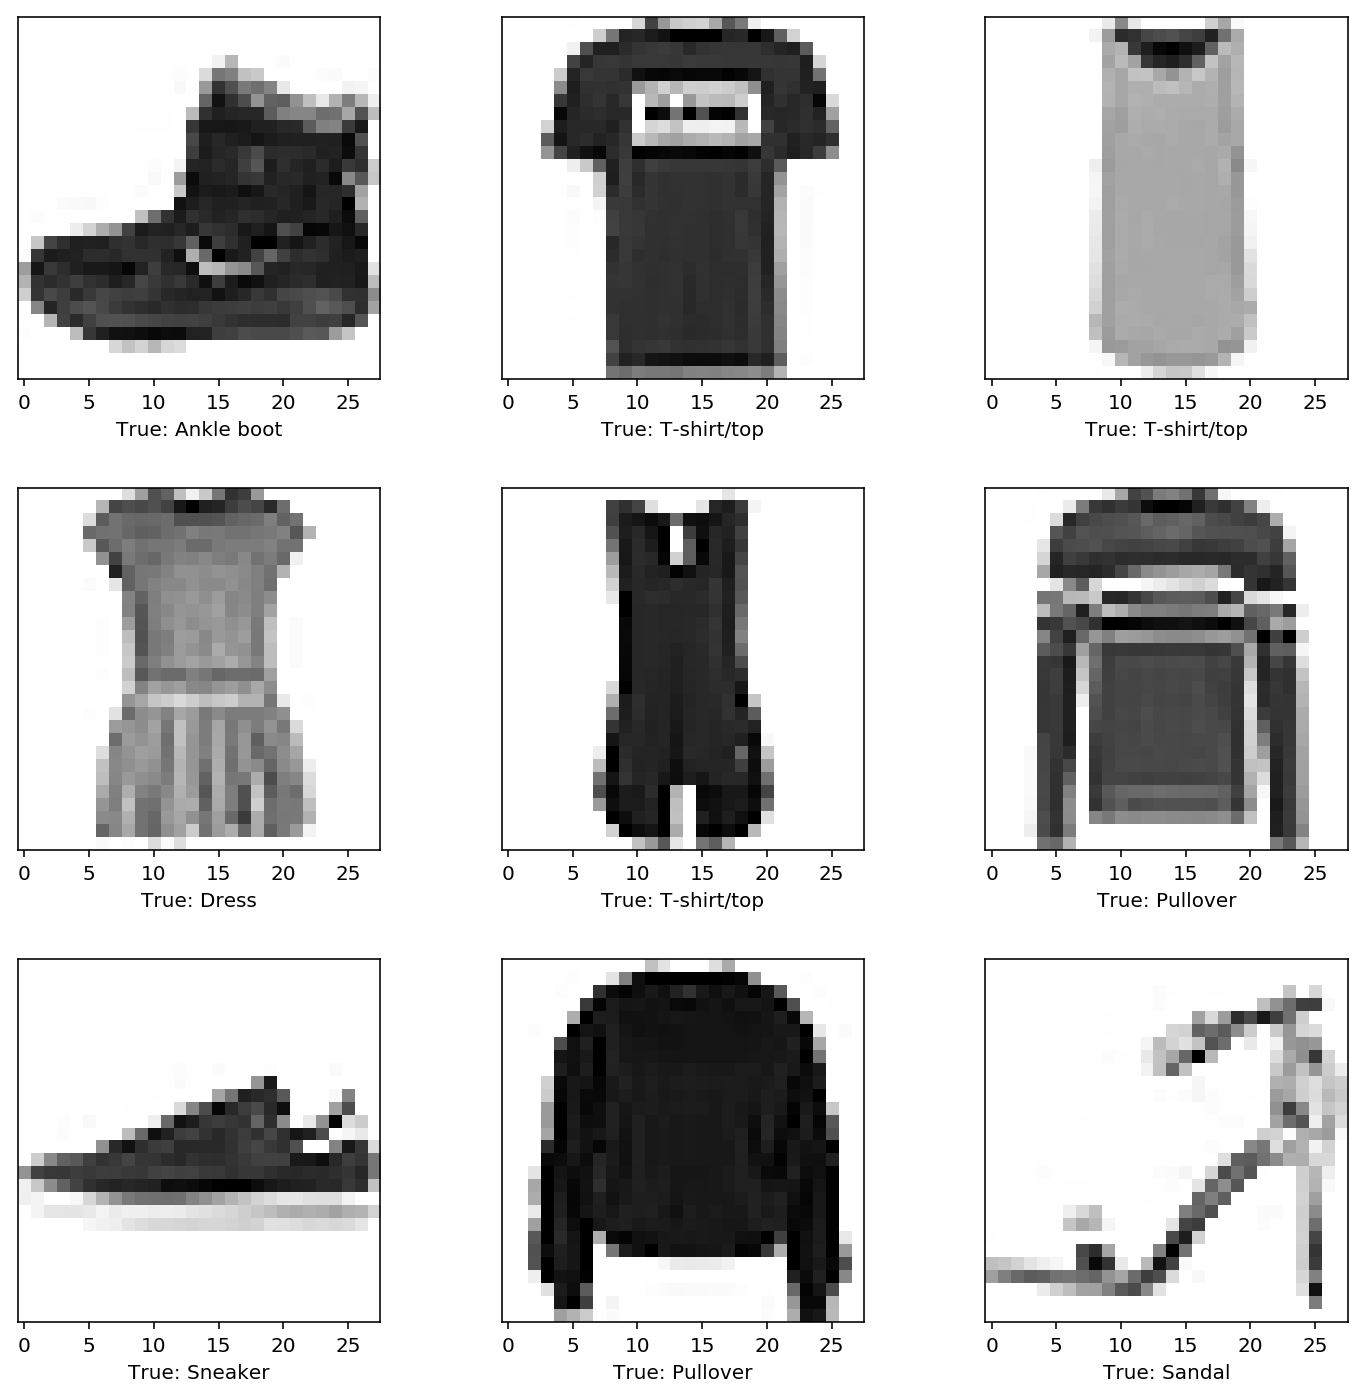

In [8]:
images = x_train[:9,:,:,:]
labels = [label_dict[x] for x in train_labels[:9]]
word_labels = [label_dict[x] for x in train_labels]
plot_image(images = images, labels = labels)

# Build Convolutional Neural Network with Tensorflow

## Set parameters

In [ ]:
# Network parameters
n_input = 784 # Fashion MNIST data input (img shape: 28*28)
n_classes = 10 # Fashion MNIST total classes (0-9 digits)
image_size = 28
input_channels = 1
n_samples, num_features =  train_images.shape

batch_size = 128
epochs = 1
num_iterations = n_samples//batch_size

n_conv_1 = 32
n_conv_2 = 64
n_conv_3 = 128
n_fl_1 = 1024 # Units in first hidden layer
n_fl_2 = 512 # Units in second hidden layer

sigma = 1e-3
LOG_DIR = 'projector'

path_to_fmnist_sprites = os.path.join(LOG_DIR,'sprites.png')
path_to_fmnist_metadata = os.path.join(LOG_DIR,'metadata.tsv')

In [ ]:
def variable_summaries(var):
    '''attach a lot of summaries to a tensorboard'''
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean',mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('steddev',stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram',var)

In [ ]:
def conv2d(x,w):
    return tf.nn.conv2d(x,w, strides=[1,1,1,1],padding ='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x, ksize = [1,2,2,1],strides = [1,2,2,1],padding ='SAME')

def avgpool2d(x): 
    return tf.reduce_mean(x,[1,2])

In [ ]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()    
    layer_flat = tf.reshape(layer,[-1,num_features])
    #now the shape should be [num_images, img_height * img_width*num_channels]
    return layer_flat, num_features

In [ ]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.1))

def new_biases(length):
    return tf.Variable(tf.constant(0.01, shape=[length]))

In [ ]:
#Convlutional Layer
def conv_fun(name,input,filter_size, pooling = True):
    with tf.variable_scope(name):
        #weights shape: [height, weight, channels, number of filters]
        input_channels = input.get_shape()[3]
        w_conv = tf.Variable(new_weights([3,3,int(input_channels),filter_size]),name = 'conv_w')
        b_conv = tf.Variable(new_biases(length = filter_size),name = 'conv_b')
        variable_summaries(w_conv)
        variable_summaries(b_conv)

        z = tf.add(conv2d(input,w_conv),b_conv)
        batch_mean, batch_var = tf.nn.moments(z,[0]) 
        scale = tf.Variable(tf.ones([filter_size]))
        beta = tf.Variable(tf.zeros([filter_size]))
        bn = tf.nn.batch_normalization(z,batch_mean, batch_var, beta, scale, sigma)

        a = tf.nn.relu(bn)
        if pooling: 
            a = maxpool2d(a)
        
    return a

In [ ]:
#Fully connected Layer
def fl_fun(name,input,output_channels,activation = False,dropout=False):
    with tf.variable_scope('full_connected'):    
        layer_flat, n_features = (input.get_shape())
        w_fc = tf.Variable(new_weights([int(n_features), output_channels]), name = 'fl_w')
        b_fc = tf.Variable(new_biases(length = output_channels), name= 'fl_b')
        variable_summaries(w_fc)
        variable_summaries(b_fc)
        
        z = tf.add(tf.matmul(input,w_fc),b_fc)
        batch_mean, batch_var = tf.nn.moments(z,[0])
        scale = tf.Variable(tf.ones([output_channels]))
        beta = tf.Variable(tf.zeros([output_channels]))
        bn = tf.nn.batch_normalization(z,batch_mean, batch_var, beta, scale, sigma)
        
        if activation: 
            bn = tf.nn.relu(bn)
        if dropout: 
            bn = tf.nn.dropout(bn,keep_prob = 0.8)
        return bn

In [ ]:
def generate(learning_rate, use_3_conv, use_3_fl):
    str_a = 3 if use_3_conv else 2
    str_b = 3 if use_3_fl else 2
    return "lr = %s, conv = %s, fl = %s" % (learning_rate,str_a,str_b)

# Create Visualization 

## Create Sprite Image

In [ ]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits

In [ ]:
to_visualise = train_images
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.figure(figsize= (20,20))
plt.imsave(path_to_fmnist_sprites,sprite_image,cmap='binary')

![title](sprite.png)

## Create metadata

In [ ]:
with open(path_to_fmnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(word_labels):
        f.write("%d\t%s\n" % (index,label))

## Create Embedding

In [ ]:
sess = tf.InteractiveSession()
embedding = tf.Variable(train_images, trainable=False, name = 'fashion')
tf.global_variables_initializer().run(session = sess)

merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(LOG_DIR,sess.graph) 

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'fashion'

# Specify where you find the metadata
embedding.metadata_path = path_to_fmnist_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_to_fmnist_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])
# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

## Save model 

In [ ]:
saver = tf.train.Saver()
config.model_checkpoint_path = os.path.join(LOG_DIR,'fashion.ckpt')
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

# Model Training

In [ ]:
def model(lr, use_3_conv, use_3_fl):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None,image_size, image_size,input_channels])
    y = tf.placeholder(tf.float32, [None, n_classes])
    tf.summary.image('input',x, n_classes)
    
    if use_3_conv:
        conv1 = conv_fun('conv1', x, n_conv_1, pooling= False)
        conv2 = conv_fun('conv2', conv1, n_conv_2, pooling = True)
        conv3 = conv_fun('conv3', conv2, n_conv_3, pooling = True)
    else: 
        conv2 = conv_fun('conv1', x, n_conv_2, pooling = True)
        conv3 = conv_fun('conv2', conv2, n_conv_3, pooling = True)
     
    pool = avgpool2d(conv3)
    
    if use_3_fl:
        fl_1 = fl_fun('fl_1',pool, n_fl_1, activation = True,dropout = False)
        fl_2 = fl_fun('fl_2', fl_1, n_fl_2, activation = True,dropout = False)
        fl_3 = fl_fun('fl_3',fl_2, n_classes, activation = False,dropout = False)
        
    else:
        fl_2 = fl_fun('fl_1', pool, n_fl_1, activation = True,dropout = False)
        fl_3 = fl_fun('fl_2',fl_2, n_classes, activation = False,dropout = False)
        
    Y = tf.nn.softmax(fl_3)
    #cross entropy
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = fl_3, labels = y)
        cost = tf.reduce_mean(cross_entropy)
        tf.summary.scalar('loss',cost)
        
    with tf.name_scope('train'):
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = lr
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step ,
                                                   10000, 0.96,staircase = True)
       
        optimizer = (
            tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step = global_step))
    
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(fl_3,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy',accuracy)
    
    sess = tf.Session()
    tf.global_variables_initializer().run(session = sess)
    train_writer = tf.summary.FileWriter('logs/train'+generate(lr,use_3_conv,use_3_fl), sess.graph)
    test_writer = tf.summary.FileWriter('logs/test'+generate(lr,use_3_conv,use_3_fl), sess.graph)

    merged = tf.summary.merge_all()
    
    with tf.name_scope('train_iterals'):
        for i in range(num_iterations*epochs):
            offset = (i*batch_size)% n_samples
            batch_x = x_train[(offset):(offset+batch_size),:]
            batch_y = y_train[offset:(offset+batch_size),:]
            if i % 5 == 0: 
                summary,acc = sess.run([merged, accuracy],feed_dict={x: batch_x, y: batch_y})
                train_writer.add_summary(summary,i)
                print('Training step '+str(i)+': '+'Train_'+generate(lr,use_3_conv,use_3_fl)+','+" acc:{:0.1%}".format(acc))
            if i % 10 == 0:
                feed_dict_test = {
                    x : x_test[:1000],
                    y: y_test[:1000]
                }
                s,acc = sess.run([merged,accuracy],feed_dict=feed_dict_test)
                test_writer.add_summary(s,i)
                print('Testing step '+str(i)+': '+'Test_'+generate(lr,use_3_conv,use_3_fl)+','+" acc:{:0.1%}".format(acc))
            
            sess.run(optimizer,feed_dict={x: batch_x, y: batch_y})


In [ ]:
for lr in [0.01,0.001]:
    # use one or two conv layers
    for use_3_conv in [True,False]:
        # use one or two fl
        for use_3_fl in [True,False]:
            # start model , and evaluate it
            model(lr,use_3_conv,use_3_fl)


In [ ]:
sess.close()

# Run TensorBoard

tensorboard --logdir name1:/path/to/logs/1,name2:/path/to/logs/2

Next, connect to http://localhost:6006.

# TensorBoard Tutorials

1. Embedding: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/
2. TensorBoard - Visualizing learning:  https://www.tensorflow.org/versions/r0.12/how_tos/summaries_and_tensorboard/
3. TensorBoard Graph Visualization: https://www.tensorflow.org/versions/r1.1/get_started/graph_viz
4. TensorBoard Repository: 
https://github.com/tensorflow/tensorboard

Reference: http://www.enpeizhao.com/?p=490